# Introduction

In this workshop, we will estimate the protective efficacy of a new vector control tool, 'ceiling nets,' using data from a hypothetical cluster-randomized controlled trial generated through computer simulation.

About ceiling nets: https://bmjopen.bmj.com/content/15/1/e087832.info

### Importing libraries

In [ ]:
# It might take some time, better to run the code in advance of the course.

install.packages("lme4")

In [ ]:
library(tidyverse)
library(MASS)
library(lme4)

In [3]:
# To make plots
theme <- theme(
            plot.title = element_text(size=20,face="bold"),
            legend.position = "top",
            legend.title = element_blank(),
            legend.text = element_text(size=18,face="bold"),
            axis.text = element_text(size=15),
            axis.title = element_text(size=18,face="bold"),
            axis.line = element_line(colour = "black"),
            plot.margin = unit(c(1, 2, 1, 1), "lines"),
            panel.background = element_blank())

# Participant list


First, you got a cohort participant list from local staff.


*   Cohort children are supposed to be aged 6 month to 14 years old.

*   Variables are the following:

    1.   **cluster_id**: ID for each cluster
    2.   **cohort_id**: Unique identifier for each participant
    3. **name_f**: First name of the participant
    4. **name_l**: Last name of the participant
    5. **birth**: Birthday of the participant
    6. **name_labtec**: Name of lab tech respondible for the cluster



In [4]:
# df_cohort <- read.csv("./list_cohort.csv")
df_cohort <- read.csv("https://raw.githubusercontent.com/KoKYura/KI_PhD_2025/main/data/list_cohort.csv")

In [ ]:
head(df_cohort,10)

In [ ]:
# How many cluster IDs?
unique(df_cohort$cluster_id)

In [ ]:
# Number of participants per cluster
df_cohort %>% count(cluster_id)

In [ ]:
# Lab tech name?
print(unique(df_cohort$name_labtec))

In [9]:
# Age of participants?
date_survey <- as.Date("2025/04/01")
df_cohort$age <- floor(interval(df_cohort$birth, date_survey) / years(1))

In [ ]:
df_cohort_age <- df_cohort %>% count(age)

ggplot(data = df_cohort_age, aes(x = age, y = n))+
  geom_bar(stat = "identity", fill = "#fdae6b", color = "#252525")+
  theme

In [ ]:
df_cohort %>% filter(age > 14)

There is the 24 y.o adult, Austin in the cohort.

Let's ask Nicole, the lab tech for cluster 'cl01'. Then, you may find that the incorrect birthday was recorded.

Her true birthday is November 30, 2020!

We need to fix the data set.

In [12]:
df_cohort <- df_cohort %>%
  mutate(birth = ifelse(cohort_id == "cl01_11", "2020/11/30", birth)) %>%
  mutate(age = ifelse(cohort_id == "cl01_11", 3, age))

In [ ]:
df_cohort %>% filter(cohort_id == "cl01_11")

In [ ]:
df_cohort_age <- df_cohort %>% count(age)

ggplot(data = df_cohort_age, aes(x = age, y = n))+
   geom_bar(stat = "identity", fill = "#fdae6b", color = "#252525")+
   theme

# Baseline data

We have the following baseline information associated with malaria outcomes.



1.   **intervention**: Intervention or Control assignment (1: intervention, 0: control)
2.   **cn**: Living in the household with ceiling net or not (1: with cn, 0: without cn)
3. **non_bn**: Not using bed net (1: non-user, 0: user)
4. **vac**: With malaria vaccination for those aged 2–6 years old (1: vaccinated)
5. **age_c**: Age category (1: age <= 2 yo, 0: age > 2 yo)
6. **rdt**: RDT results


In [ ]:
# df_baseline <- read.csv("./data_baseline.csv")
df_baseline <- read.csv("https://raw.githubusercontent.com/KoKYura/KI_PhD_2025/main/data/data_baseline.csv")

head(df_baseline)

Transmission heterogeneity

In [ ]:
df_prev <- df_baseline %>%
  group_by(cluster_id) %>%
  count(rdt) %>%
  mutate(prev = n/sum(n)) %>%
  filter(rdt == 1) %>%
  arrange(prev) %>%
  ungroup() %>%
  mutate(order = row_number())

ggplot(data = df_prev, aes(x = order, y = prev))+
   geom_bar(stat = "identity", fill = "#fc4e2a", color = "#252525")+
   theme+
   theme(
          axis.title.x = element_blank(),
          axis.text.x = element_blank()
   )

# Analysis of perfect data

Suppose that we know the potential non-compliers, even those in the control arm.

**non_comp**: 1: non complier, 0: complier

In [ ]:
# df_full <- read.csv("./data_cohort_full.csv")
df_full <- read.csv("https://raw.githubusercontent.com/KoKYura/KI_PhD_2025/main/data/data_cohort_full.csv")

head(df_full)

In [ ]:
head(df_full %>% filter(intervention == 1 & non_comp == 1))

In [19]:
df_full_count <- df_full %>%
    group_by(cohort_id) %>%
    summarise(
    num_pos = sum(outcome),
    total_visit = n()
  )

In [20]:
df_full2 <- df_full %>%
    dplyr::select(cluster_id, cohort_id, intervention, cn, non_comp, non_bn, vac, age_c) %>%
    left_join(df_full_count, by = "cohort_id") %>%
    distinct(cohort_id, .keep_all = T)

**Analysis**

**Mixed-effects negative binomial regression**


\begin{align*}
y_{ij} &\sim NegBin(\lambda_{ij}, \theta) \\
{\lambda_{ij}} &= exp(\alpha + x_{ij}^T\beta + u_j + log{A_{ij}})  \\
\ u_j &\sim N(0, \sigma_{u}^2) \\
\end{align*}

where $y_{ij}$ denotes the total number of clinical malaria diagnosis for individual $i$ in a cluster $j$, $x_{i,j}$ is the covariate vector, $u_{j}$ is the Gaussian-type randome effect at the cluster level, $A_{ij}$ is the total number of visits.

The protective efficacy will be estimated by $(1 − exp(𝛽_{1}))$ × 100%, where $𝛽_{1}$ is the estimated regression coefficient of
the treatment.

In [21]:
model <- glmer.nb(num_pos ~
                       cn +
                       non_comp +
                       non_bn +
                       vac +
                       age_c +
                       offset(log(total_visit)) +
                       (1 | cluster_id), data = df_full2)

In [ ]:
print(exp(fixef(model)))
exp(confint(model, parm = "beta_", method = "Wald"))

print(paste0("Estimated efficacy of the ceiling net: ", round(1-exp(fixef(model))[[2]],2)))

In [34]:
# TODO 1: write your code here

# Intention-to-Treat
model_itt <-



In [ ]:
print(exp(fixef(model_itt)))
exp(confint(model_itt, parm = "beta_", method = "Wald"))

print(paste0("Estimated efficacy of the ceiling net: ", round(1-exp(fixef(model_itt))[[2]],2)))

In [36]:
# TODO 2: write your code here

# Per protocol
model_pp <-


In [ ]:
print(exp(fixef(model_pp)))
exp(confint(model_pp, parm = "beta_", method = "Wald"))

print(paste0("Estimated efficacy of the ceiling net: ", round(1-exp(fixef(model_pp))[[2]],2)))

# Analysis of raw data

If you get to know who is the non complier, then we can estimate the data perfectly, but in reality it is not possible.



*   **symp**: 1: with malaria related symptoms
*   **rdt**: 1: malaria RDT positive



In [ ]:
# df_raw <- read.csv("./data_cohort_raw.csv")
df_raw <- read.csv("https://raw.githubusercontent.com/KoKYura/KI_PhD_2025/main/data/data_cohort_raw.csv")

head(df_raw)

We need the variable for clinical malaria, defined as having both symptoms and a positive RDT result.


In [24]:
df_raw2 <- df_raw %>%
    mutate(outcome = ifelse(rdt == 1 & symp == 1, 1, 0))

In [ ]:
head(df_raw2)

In [26]:
df_raw_count <- df_raw2 %>%
    group_by(cohort_id) %>%
    summarise(
    num_pos = sum(outcome,na.rm=T),
    total_visit = sum(avail)
  )




*   Combine with the baseline covariates
*   Calcluate incidence rate per person-year



In [ ]:
df_raw3 <- left_join(df_raw_count, df_baseline) %>%
    distinct(cohort_id, .keep_all = T) %>%
    mutate(incidence_rate = 12*num_pos/total_visit)

Get estimates

  - Intention to treat vs Per protocol

In [28]:
# Intention to Treat
model_raw_itt <- glmer.nb(num_pos ~
                       intervention +
                       non_bn +
                       vac +
                       age_c +
                    　 offset(log(total_visit)) +
                       (1 | cluster_id), data = df_raw3)

In [29]:
# Per protocol
model_raw_pp <- glmer.nb(num_pos ~ cn +
                       non_bn +
                       vac +
                       age_c +
                    　　offset(log(total_visit)) +
                       (1 | cluster_id), data = df_raw3)

In [ ]:
# Intention to Treat
print(exp(fixef(model_raw_itt)))
exp(confint(model_raw_itt, parm = "beta_", method = "Wald"))

print(paste0("Estimated efficacy of the ceiling net: ", round(1-exp(fixef(model_raw_itt))[[2]],2)))

In [ ]:
# Per protocol
print(exp(fixef(model_raw_pp)))
exp(confint(model_raw_pp, parm = "beta_", method = "Wald"))


print(paste0("Estimated efficacy of the ceiling net: ", round(1-exp(fixef(model_raw_pp))[[2]],2)))

In [ ]:
# Compare with the perfect data
m_raw_itt <- 1-exp(fixef(model_raw_itt))[[2]]
l_raw_itt <- 1-exp(confint(model_raw_itt, parm = "beta_", method = "Wald"))[[2,2]]
u_raw_itt <- 1-exp(confint(model_raw_itt, parm = "beta_", method = "Wald"))[[2,1]]

m_full_itt <- 1-exp(fixef(model_itt))[[2]]
l_full_itt <- 1-exp(confint(model_itt, parm = "beta_", method = "Wald"))[[2,2]]
u_full_itt <- 1-exp(confint(model_itt, parm = "beta_", method = "Wald"))[[2,1]]

data_res <- tibble(data = c("Raw data", "Perfect data"),
                   est = c(m_raw_itt, m_full_itt),
                   l = c(l_raw_itt, l_full_itt),
                   u = c(u_raw_itt, u_full_itt))

ggplot(data_res, aes(x = data, y = est)) +
  ylab("Estimated protective efficacy") +
  geom_point(size = 7) +
  geom_errorbar(aes(ymin = l, ymax = u), width = 0.1) +
  coord_flip() +
  theme +
  geom_hline(yintercept = 0.5, linetype = 2)

# Excercise

It appears that the raw data contains both **random** and **systematic** errors when compared to the perfect data.

Let’s identify all the missing or measurement errors (**5 errors**)!

Each time you find something suspicious, ask the field staff to investigate what’s happening in the field. They will then provide you with the correct information.

In [ ]:
# TODO 3: write your code here
# To detect errors

In [ ]:
# TODO 4: write your code here
# To update for correct data

# Data simulation (reference)


**Data generation process**

1.   **Cluster-level random effect**: mean = 0, sd = 0.5
2.   **Intervention**: Randomly assign 50% of participants to receive the intervention, which reduces the risk of clinical malaria by 50%.
3.   **Compliance**: 10% of participants do not receive the intervention when allocated to the intervention arm due to a lack of health awareness; these individuals have a 20% higher risk of clinical malaria.
4.   **Bed net use**: 20% of participants do not use bed nets regularly and have a 40% higher risk of clinical malaria.
5.   **Malaria vaccine**: 70% of children aged 2–6 years receive a malaria vaccine, which reduces the risk of clinical malaria by 30%.
6. **Age**: Children aged 0–2 years have a 50% higher risk of clinical malaria compared to older children.

Without any of the above risk factors, the incidence rate is 1.5 per person-year, following a negative binomial distribution with a dispersion parameter of 1.2


\begin{align*}
y_{ij} &\sim NegBin(\lambda_{ij}, \theta) \\
{\lambda_{ij}} &= exp(\alpha + x_{ij}^T\beta + u_j + log{A_{ij}})  \\
\ u_j &\sim N(0, \sigma_{u}^2) \\
\end{align*}

where $y_{ij}$ denotes the total number of clinical malaria diagnosis for individual $i$ in a cluster $j$, $x_{i,j}$ is the covariate vector, $u_{j}$ is the Gaussian-type randome effect at the cluster level, $A_{ij}$ is the total number of visits.

The protective efficacy will be estimated by $(1 − exp(𝛽_{1}))$ × 100%, where $𝛽_{1}$ is the estimated regression coefficient of
the treatment.







In [ ]:
df_cohort <- read.csv("./data/list_cohort.csv")
date_survey <- as.Date("2025/04/01")
df_cohort_2 <- df_cohort %>%
  mutate(birth = ifelse(cohort_id == "cl01_11", "2020/11/30", birth)) %>%
  mutate(age = floor(interval(birth, date_survey) / years(1))) %>%
  group_by(cluster_id) %>%
  mutate(re = rnorm(1, mean = 0, sd = 0.3)) %>%
  mutate(intervention = ifelse(as.numeric(str_extract(cluster_id, "\\d+")) %% 2 == 1,1,0)) %>%
  ungroup() %>%
  mutate(non_comp = rbinom(nrow(df_cohort), 1, 0.10),
         non_bn = rbinom(nrow(df_cohort), 1, 0.2),
         vac = case_when(age >= 2 & age <= 6 ~ rbinom(nrow(df_cohort), 1, 0.70),
                         TRUE ~ 0),
         age_c = ifelse(age <= 2, 1, 0)) %>% # 1: young, 0: old
  mutate(cn = ifelse(intervention == 1 & non_comp == 0, 1, 0))

In [ ]:
lambda <- exp(log(1.5)+df_cohort_2$re+
            log(0.5)*df_cohort_2$cn+
            log(1.2)*df_cohort_2$non_comp+
            log(1.4)*df_cohort_2$non_bn+
            log(0.7)*df_cohort_2$vac+
            log(1.5)*df_cohort_2$age_c
            )
theta <- 1.2
num_pos <- rnegbin(nrow(df_cohort_2), mu = lambda, theta = theta)
df_cohort_2$num_pos <- num_pos

In [ ]:
print(df_cohort_2$num_pos)

  [1]  1  0  1  0  1  2  1  0  0  0  0  0  0  2  0  2  0  0  0  0  1  0  2  0  0
 [26]  0  3  0  1  0  3  0  4  1  0  0  0  1  1  1  1  1  0  0  3  1  1  1  2  0
 [51]  4  1  0  0  0  0  1  0  1  0  0  3  0  0  1  6  0  0  2  4  2  0  0  5  0
 [76]  2  0  0  1  0  1  2  0  6  0  2  1  0  6  0  0  1  1  0  0  3  3  4  2  4
[101]  0  1  0  1  1  1  3  0  1  0  1  0  1  0  4  7  1  3  1  2  1  2  0  2  2
[126]  1  2  3  1  5  2  5  1  1  4  3  8  3  1  2  1  3  2  0  0  0  5  2  0  0
[151] 10  0  2  2  6  2  0  2  2  0  0  0  0  0  0  3  4  0  1  0  0  2  1  0  0
[176]  3  1  1  0  3  1  0  1  0  0  0  2  0  0  4  5  0  1  0  1  4  0  3  3  0
[201]  5  2  0  3  0  2  1  6  2  2  1  0  2  3  1  9  4  0  1  4  6  1  5  0  0
[226]  0  0  7  5  0  4  2  1  0  9  0  0  1  1  2  0  0  1  2  0  1  1  0  0  1
[251]  0  4  1  0  2  2  0  0  1  1  0  1  2  0  3  0  4  0  0  3  0  1  1  1  1
[276]  0  3  1  1  0  0  3  8  0  0  0  1  0  3  4  0  2  0  3  0  0  1  0  0  1
[301]  4  2  1  3  1  1  0  

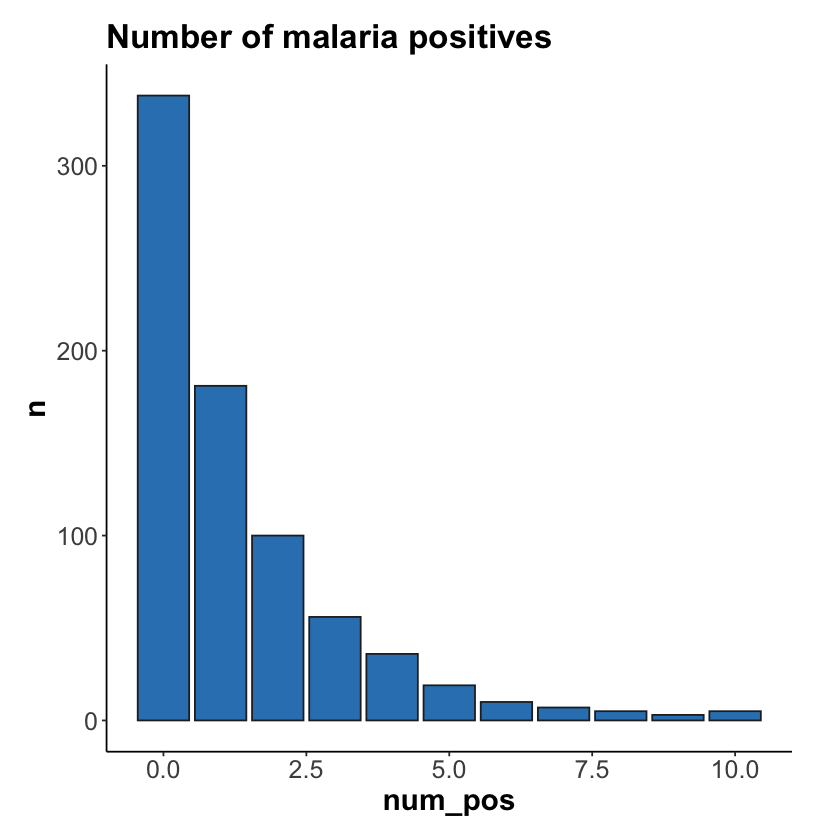

In [ ]:
df_num_pos <- df_cohort_2 %>% count(num_pos)

ggplot(data = df_num_pos, aes(x = num_pos, y = n))+
   geom_bar(stat = "identity", fill = "#3182bd", color = "#252525")+
   ggtitle("Number of malaria positives")+
   theme